# Preprocessing the data

In [2]:
import LoadUtils
import pandas as pd

PATH_BUSINESS = 'yelp_dataset/yelp_academic_dataset_business.json'
PATH_REVIEW = 'yelp_dataset/yelp_academic_dataset_review.json'

In [3]:
# Filter for OPEN ONLY businesses in California
data_business = LoadUtils.load_matches(PATH_BUSINESS, verbose=True,
                                       func=LoadUtils.fn_all,
                                       args=[(LoadUtils.fn_eq, "state", "CA"),
                                             (LoadUtils.fn_eq, "is_open", 1)])
business_ca_open = pd.DataFrame(data_business)

# Display filtered data
print(f"Number of open businesses in California: {business_ca_open.shape[0]}")
print(business_ca_open.head())

Now loading yelp_dataset/yelp_academic_dataset_business.json
[**] Loaded 4065/150345 entries (0 unprocessable)
Number of open businesses in California: 4065
              business_id                             name  \
0  noByYNtDLQAra9ccqxdfDw                              H&M   
1  IDtLPgUrqorrpqSLdfMhZQ             Helena Avenue Bakery   
2  nUqrF-h9S7myCcvNDecOvw             Iron Horse Auto Body   
3  bYjnX_J1bHZob10DoSFkqQ      Tinkle Belle Diaper Service   
4  SZU9c8V2GuREDN5KgyHFJw  Santa Barbara Shellfish Company   

                 address           city state postal_code   latitude  \
0       827-833 State St  Santa Barbara    CA       93101  34.420209   
1  131 Anacapa St, Ste C  Santa Barbara    CA       93101  34.414445   
2         825 Cacique St  Santa Barbara    CA       93103  34.419620   
3                         Santa Barbara    CA       93101  34.420334   
4      230 Stearns Wharf  Santa Barbara    CA       93101  34.408715   

    longitude  stars  review_count  i

In [4]:
biz_ids = set()
for item in data_business:
    biz_ids.add(item["business_id"])

# full data is 7 million entries, so this takes pretty long (around 3 minutes)
data_review = LoadUtils.load_matches(PATH_REVIEW, verbose=True, n_lines=100000,
                                     func=LoadUtils.fn_in,
                                     args=("business_id", biz_ids))

# Merge only reviews for open businesses in California
review_df = pd.DataFrame(data_review)

Now loading yelp_dataset/yelp_academic_dataset_review.json
[====================] Loaded 3869/100000 entries (0 unprocessable)


In [5]:
review_ca_open = review_df.merge(business_ca_open[['business_id', 'name', 'categories']], on='business_id')

# Display filtered reviews
print(f"Number of reviews for open businesses in California: {review_ca_open.shape[0]}")
print(review_ca_open.head())

Number of reviews for open businesses in California: 3869
                review_id                 user_id             business_id  \
0  ZKvDG2sBvHVdF5oBNUOpAQ  wSTuiTk-sKNdcFyprzZAjg  B5XSoSG3SfvQGtKEGQ1tSQ   
1  9ag-bC-521T1i3IypXr4Ug  sx_cqxyWRUoOIoy_AXmLdQ  B5XSoSG3SfvQGtKEGQ1tSQ   
2  80p5xO3dbpd80T6vPTL8DQ  D7ct4p7uUk5t4LFSjVnO4A  B5XSoSG3SfvQGtKEGQ1tSQ   
3  pUycOfUwM8vqX7KjRRhUEA  59MxRhNVhU9MYndMkz0wtw  gebiRewfieSdtt17PTW6Zg   
4  _Ub20uO1MKy4XOVPOdzpqw  lUYboGI6aFbZ0dX27pijpA  gebiRewfieSdtt17PTW6Zg   

   stars  useful  funny  cool  \
0    3.0       1      1     0   
1    4.0       1      0     0   
2    5.0       0      0     0   
3    3.0       0      0     0   
4    1.0       0      2     0   

                                                text                 date  \
0  This easter instead of going to Lopez Lake we ...  2016-03-30 22:46:33   
1  I work with a college group that does camping ...  2013-09-07 21:16:36   
2  My SO and I love exploring new trails and so i

In [6]:
# this cell takes pretty long on the full data, 4-5 minutes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Convert the textual reviews into a numerical representation using TF-IDF (Term Frequency-Inverse Document Frequency)
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit to 5000 most important terms
review_tfidf = tfidf.fit_transform(review_ca_open['text'])

print(f"TF-IDF Matrix Shape: {review_tfidf.shape}")  # High-dimensional representation

# Apply Dimentionality Reduction using Principal Component Analysis (PCA)
pca = PCA(n_components=50)  # Reduce to 50 components
reduced_reviews = pca.fit_transform(review_tfidf.toarray())

print(f"Reduced Dimensions Shape: {reduced_reviews.shape}")  # Lower-dimensional representation

TF-IDF Matrix Shape: (3869, 5000)
Reduced Dimensions Shape: (3869, 50)


# Clustering

Now clustering with k= 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 19... 20... 21... 22... 23... 24... 25... 26... 27... 28... 29...

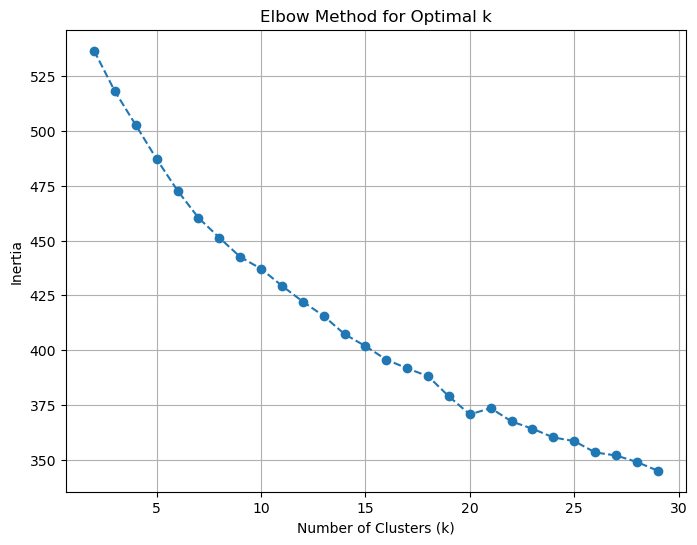

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Associate reduced review features with businesses
business_features = pd.DataFrame(reduced_reviews, columns=[f'PC{i+1}' for i in range(reduced_reviews.shape[1])])
business_features['business_id'] = review_ca_open['business_id'].values

# Determine the best number of clusters using Elbow Method
inertia = []
k_values = range(2, 30)

print("Now clustering with k=", end='')
for k in k_values:
    print(f" {k}...", end='')
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(business_features.drop(columns=['business_id']))
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [9]:
# Apply K-Means with the chosen number of clusters based on the Elbow Curve
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
business_features['cluster'] = kmeans.fit_predict(business_features.drop(columns=['business_id']))

# Merge cluster labels back to business data
business_clusters = business_features[['business_id', 'cluster']].merge(
    business_ca_open[['business_id', 'name', 'categories']], on='business_id'
)

# Display sample results
print(business_clusters.head())

              business_id  cluster                             name  \
0  B5XSoSG3SfvQGtKEGQ1tSQ        9       Los Padres National Forest   
1  B5XSoSG3SfvQGtKEGQ1tSQ        9       Los Padres National Forest   
2  B5XSoSG3SfvQGtKEGQ1tSQ        9       Los Padres National Forest   
3  gebiRewfieSdtt17PTW6Zg        3  Hibachi Steak House & Sushi Bar   
4  gebiRewfieSdtt17PTW6Zg        3  Hibachi Steak House & Sushi Bar   

                                       categories  
0                              Parks, Active Life  
1                              Parks, Active Life  
2                              Parks, Active Life  
3  Steakhouses, Sushi Bars, Restaurants, Japanese  
4  Steakhouses, Sushi Bars, Restaurants, Japanese  


# Output

In [11]:
# Merge user reviews with clusters to determine user interactions
user_cluster_data = review_ca_open.merge(
    business_clusters[['business_id', 'cluster']], on='business_id'
)

# Assign users to their most-interacted cluster
user_cluster_pref = user_cluster_data.groupby(['user_id', 'cluster']).size().reset_index(name='review_count')

# Find the cluster with the highest review count for each user
user_pref_cluster = user_cluster_pref.loc[
    user_cluster_pref.groupby('user_id')['review_count'].idxmax()
].rename(columns={'cluster': 'preferred_cluster'})

# Recommend businesses from the preferred cluster
def recommend_businesses(user_id, num_recommendations=5):
    # Check if the user exists in the preference data
    if user_id not in user_pref_cluster['user_id'].values:
        return f"User {user_id} has no interactions recorded."

    # Get the user's preferred cluster
    preferred_cluster = user_pref_cluster[user_pref_cluster['user_id'] == user_id]['preferred_cluster'].values[0]
    
    # Get all businesses in this cluster
    cluster_businesses = business_clusters[business_clusters['cluster'] == preferred_cluster]
    
    # Exclude businesses the user has already reviewed
    reviewed_businesses = user_cluster_data[user_cluster_data['user_id'] == user_id]['business_id'].unique()
    recommendations = cluster_businesses[~cluster_businesses['business_id'].isin(reviewed_businesses)]
    
    # Select top businesses for recommendation (or fewer if less available)
    return recommendations[['name', 'categories']].sample(n=min(num_recommendations, len(recommendations)))

In [12]:
# Example: Generate recommendations for a user
user_id_example = user_cluster_data['user_id'].iloc[42]  # recommend for the first user in the dataset
recommendations = recommend_businesses(user_id_example, num_recommendations=5)
print(f"Recommendations for User {user_id_example}:\n", recommendations)

Recommendations for User 59MxRhNVhU9MYndMkz0wtw:
                              name  \
2179                   Sushi Tyme   
2270  Sakana Sushi Bar & Japanese   
1466                      Ichiban   
1457                      Ichiban   
2051              Sushiya Express   

                                             categories  
2179  Restaurants, Asian Fusion, Seafood, Sushi Bars...  
2270                  Sushi Bars, Japanese, Restaurants  
1466                  Restaurants, Japanese, Sushi Bars  
1457                  Restaurants, Japanese, Sushi Bars  
2051  Sushi Bars, Caterers, Food, Fast Food, Event P...  
